<a href="https://colab.research.google.com/github/hrnnikolov/ML_models/blob/main/vin_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [580]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn

data = yf.download(tickers='AAPL', start='2010-01-01', end='2024-02-28')
data.head(10)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

[*********************100%%**********************]  1 of 1 completed


'cpu'

In [581]:
data['Target'] = data['Adj Close'] - data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()

data['EMA_change'] = 0.0
data['EMA_change'] = np.where( data['EMA_50'] > data['EMA_200'], 1, 0 )

#data['short_EMA_change'] = np.where(data['EMA_change'] == data['EMA_change'].shift(), 0, 1)

data.dropna(inplace=True)
data.reset_index(inplace=True)

In [582]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Target,TargetClass,TargetNextClose,EMA_50,EMA_200,EMA_change
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470743,493729600,-1.182358,0,6.481928,7.643214,7.643214,0
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481928,601904800,-1.277604,0,6.378825,7.643732,7.643346,1
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378825,552160000,-1.195467,0,6.367033,7.639454,7.642264,0
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200,-1.101352,0,6.409362,7.634798,7.641055,0
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409362,447610800,-1.247178,0,6.352822,7.632285,7.640355,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3555,2024-02-20,181.789993,182.429993,180.000000,181.559998,181.559998,53665600,0.380005,1,182.320007,187.509200,180.713363,1
3556,2024-02-21,181.940002,182.889999,180.660004,182.320007,182.320007,41529700,0.889999,1,184.369995,187.305703,180.729350,1
3557,2024-02-22,183.479996,184.960007,182.460007,184.369995,184.369995,52292200,-2.489990,0,182.520004,187.190577,180.765575,1
3558,2024-02-23,185.009995,185.039993,182.229996,182.520004,182.520004,45119700,-1.080002,0,181.160004,187.007417,180.783032,1


In [583]:
df = data[['Date', 'Target']]

In [584]:
df

,Date,Target
0,2010-01-04,-1.182358
1,2010-01-05,-1.277604
2,2010-01-06,-1.195467
3,2010-01-07,-1.101352
4,2010-01-08,-1.247178
...,...,...
3555,2024-02-20,0.380005
3556,2024-02-21,0.889999
3557,2024-02-22,-2.489990
3558,2024-02-23,-1.080002


In [585]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Target(t-{i})'] = df['Target'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 0
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

,Target
Date,
2010-01-04,-1.182358
2010-01-05,-1.277604
2010-01-06,-1.195467
2010-01-07,-1.101352
2010-01-08,-1.247178
...,...
2024-02-20,0.380005
2024-02-21,0.889999
2024-02-22,-2.489990


In [586]:
test_df = pd.merge(shifted_df, data, how='left', on='Target')
test_df.dropna()

,Target,Date,Open,High,Low,Close,Adj Close,Volume,TargetClass,TargetNextClose,EMA_50,EMA_200,EMA_change
0,-1.182358,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470743,493729600,0,6.481928,7.643214,7.643214,0
1,-1.277604,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481928,601904800,0,6.378825,7.643732,7.643346,1
2,-1.195467,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378825,552160000,0,6.367033,7.639454,7.642264,0
3,-1.101352,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200,0,6.409362,7.634798,7.641055,0
4,-1.247178,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409362,447610800,0,6.352822,7.632285,7.640355,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3571,0.380005,2024-02-20,181.789993,182.429993,180.000000,181.559998,181.559998,53665600,1,182.320007,187.509200,180.713363,1
3572,0.889999,2024-02-21,181.940002,182.889999,180.660004,182.320007,182.320007,41529700,1,184.369995,187.305703,180.729350,1
3573,-2.489990,2024-02-22,183.479996,184.960007,182.460007,184.369995,184.369995,52292200,0,182.520004,187.190577,180.765575,1
3574,-1.080002,2024-02-23,185.009995,185.039993,182.229996,182.520004,182.520004,45119700,0,181.160004,187.007417,180.783032,1


In [587]:
test_df['Average'] = test_df['High'] - test_df['Low']
test_df1 = test_df.drop([#'High', 'Low',
                         'TargetClass', 'TargetNextClose', 'Adj Close'], axis=1)
test_df1.set_index('Date', inplace=True)
test_df1

,Target,Open,High,Low,Close,Volume,EMA_50,EMA_200,EMA_change,Average
Date,,,,,,,,,,
2010-01-04,-1.182358,7.622500,7.660714,7.585000,7.643214,493729600,7.643214,7.643214,0,0.075714
2010-01-05,-1.277604,7.664286,7.699643,7.616071,7.656429,601904800,7.643732,7.643346,1,0.083572
2010-01-06,-1.195467,7.656429,7.686786,7.526786,7.534643,552160000,7.639454,7.642264,0,0.160000
2010-01-07,-1.101352,7.562500,7.571429,7.466071,7.520714,477131200,7.634798,7.641055,0,0.105358
2010-01-08,-1.247178,7.510714,7.571429,7.466429,7.570714,447610800,7.632285,7.640355,0,0.105000
...,...,...,...,...,...,...,...,...,...,...
2024-02-20,0.380005,181.789993,182.429993,180.000000,181.559998,53665600,187.509200,180.713363,1,2.429993
2024-02-21,0.889999,181.940002,182.889999,180.660004,182.320007,41529700,187.305703,180.729350,1,2.229996
2024-02-22,-2.489990,183.479996,184.960007,182.460007,184.369995,52292200,187.190577,180.765575,1,2.500000


In [588]:
shifted_df_as_np = test_df1.to_numpy()
#shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[-1.18235826e+00,  7.62249994e+00,  7.66071415e+00, ...,
         7.64321423e+00,  0.00000000e+00,  7.57141113e-02],
       [-1.27760410e+00,  7.66428614e+00,  7.69964314e+00, ...,
         7.64334571e+00,  1.00000000e+00,  8.35719109e-02],
       [-1.19546652e+00,  7.65642881e+00,  7.68678617e+00, ...,
         7.64226410e+00,  0.00000000e+00,  1.60000324e-01],
       ...,
       [-2.48999023e+00,  1.83479996e+02,  1.84960007e+02, ...,
         1.80765575e+02,  1.00000000e+00,  2.50000000e+00],
       [-1.08000183e+00,  1.85009995e+02,  1.85039993e+02, ...,
         1.80783032e+02,  1.00000000e+00,  2.80999756e+00],
       [ 1.52999878e+00,  1.82240005e+02,  1.82759995e+02, ...,
         1.80786783e+02,  1.00000000e+00,  2.11000061e+00]])

In [589]:
shifted_df_as_np.shape

(3576, 10)

In [590]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.08586413, -0.99213032, -0.99313971, ..., -0.99852227,
        -1.        , -0.99518777],
       [-0.09674669, -0.99169311, -0.99273551, ..., -0.99852075,
         1.        , -0.99395662],
       [-0.08736184, -0.99177533, -0.992869  , ..., -0.99853324,
        -1.        , -0.98198194],
       ...,
       [-0.23527104,  0.8478678 ,  0.84778332, ...,  0.99975521,
         1.        , -0.61535442],
       [-0.07416912,  0.86387618,  0.84861383, ...,  0.9999567 ,
         1.        , -0.56678448],
       [ 0.22404333,  0.83489377,  0.82494029, ...,  1.        ,
         1.        , -0.67645892]])

In [591]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3576, 9), (3576,))

In [592]:
#X = dc(np.flip(X, axis=1))
X

array([[-0.99213032, -0.99313971, -0.99168943, ..., -0.99852227,
        -1.        , -0.99518777],
       [-0.99169311, -0.99273551, -0.99136272, ..., -0.99852075,
         1.        , -0.99395662],
       [-0.99177533, -0.992869  , -0.99230155, ..., -0.99853324,
        -1.        , -0.98198194],
       ...,
       [ 0.8478678 ,  0.84778332,  0.84711268, ...,  0.99975521,
         1.        , -0.61535442],
       [ 0.86387618,  0.84861383,  0.84469413, ...,  0.9999567 ,
         1.        , -0.56678448],
       [ 0.83489377,  0.82494029,  0.82808049, ...,  1.        ,
         1.        , -0.67645892]])

In [593]:
split_index = int(len(X) * 0.95)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3397, 9), (179, 9), (3397,), (179,))

In [594]:
X_train.shape[1] #тука тензор

9

In [595]:
X_train = X_train.reshape((-1, X_train.shape[1], 1))
X_test = X_test.reshape((-1, X_test.shape[1], 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3397, 9, 1), (179, 9, 1), (3397, 1), (179, 1))

In [596]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3397, 9, 1]),
 torch.Size([179, 9, 1]),
 torch.Size([3397, 1]),
 torch.Size([179, 1]))

In [597]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [598]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [599]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 9, 1]) torch.Size([32, 1])


In [600]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, mid_layers_size, bigger_inputs ):
        super().__init__()
        #this
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.mid_layers_size = mid_layers_size
        self.bigger_inputs = bigger_inputs

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers=self.num_stacked_layers,
                            batch_first=True)

        #this
        self.lstm2 = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size,
                             num_layers=self.num_stacked_layers, batch_first=True)


        self.fc = nn.Linear(hidden_size, self.mid_layers_size)
        self.leacky_relu = nn.LeakyReLU(0.2)
        self.layer_2 = nn.Linear(in_features=self.mid_layers_size, out_features=bigger_inputs)
        self.layer_3 = nn.Linear(in_features=bigger_inputs, out_features=self.mid_layers_size)
        self.layer_4 = nn.Linear(in_features=self.mid_layers_size, out_features=1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        #this
        h1 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c1 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        #this
        #out, _ = self.lstm2(out, (h1,c1))

        out = self.layer_4(self.leacky_relu(self.layer_3(self.leacky_relu(self.layer_2(self.leacky_relu(self.fc(out[:, -1, :])))))))
        # out, _ = self.lstm(out, (h0, c0))
        # out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 2, 32, 64)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, num_layers=2, batch_first=True)
  (lstm2): LSTM(4, 4, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4, out_features=32, bias=True)
  (leacky_relu): LeakyReLU(negative_slope=0.2)
  (layer_2): Linear(in_features=32, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=32, bias=True)
  (layer_4): Linear(in_features=32, out_features=1, bias=True)
)

In [601]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device).type(torch.float32), batch[1].to(device).type(torch.float32)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print(f'Batch {batch_index+1}, Loss: {avg_loss_across_batches:.3f}')#.format(batch_index+1,avg_loss_across_batches))
            running_loss = 0.0
    print()

In [602]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device).type(torch.float32), batch[1].to(device).type(torch.float32)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [603]:
#from torchmetrics.regression import MeanAbsolutePercentageError

learning_rate = 0.01
num_epochs = 2000
#loss_function = MeanAbsolutePercentageError()
#loss_function = nn.L1Loss()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Streaming output truncated to the last 5000 lines.
***************************************************

Epoch: 1168
Batch 100, Loss: 0.016

Val Loss: 0.077
***************************************************

Epoch: 1169
Batch 100, Loss: 0.016

Val Loss: 0.075
***************************************************

Epoch: 1170
Batch 100, Loss: 0.017

Val Loss: 0.063
***************************************************

Epoch: 1171
Batch 100, Loss: 0.017

Val Loss: 0.076
***************************************************

Epoch: 1172
Batch 100, Loss: 0.017

Val Loss: 0.074
***************************************************

Epoch: 1173
Batch 100, Loss: 0.017

Val Loss: 0.094
***************************************************

Epoch: 1174
Batch 100, Loss: 0.016

Val Loss: 0.081
***************************************************

Epoch: 1175
Batch 100, Loss: 0.017

Val Loss: 0.092
***************************************************

Epoch: 1176
Batch 100, Loss: 0.017

Val Loss: 0.095
****

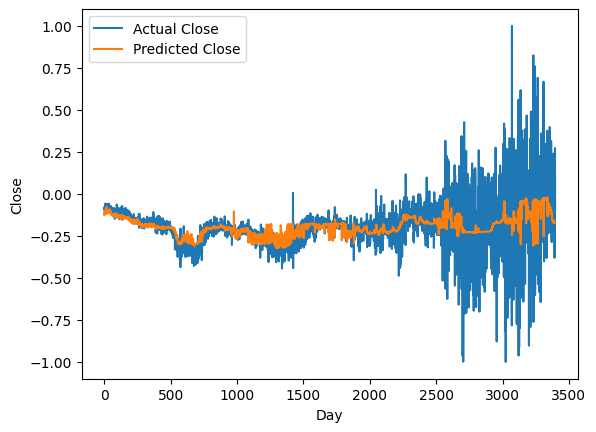

In [604]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

#plt.plot(y_train[3600:], label='Actual Close')
#plt.plot(predicted[3600:], label='Predicted Close')
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [605]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], X_train.shape[1]+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([-1.43669572, -1.53662843, -1.37886298, ..., -1.94231376,
       -1.93277309, -1.93417259])

In [606]:
dummies = np.zeros((X_train.shape[0], X_train.shape[1]+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([-1.18235827, -1.27760412, -1.19546651, ..., -1.319458  ,
        1.95973217, -1.25180055])

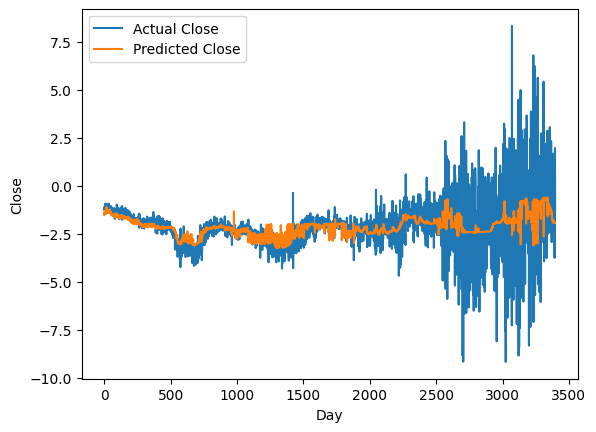

In [607]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [608]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], X_train.shape[1]+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])

In [609]:
dummies = np.zeros((X_test.shape[0], X_train.shape[1]+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

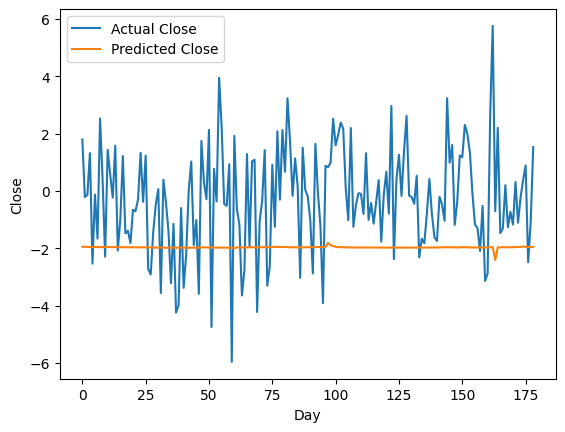

In [610]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [611]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

In [612]:
X_test[-1]

tensor([[ 0.8349],
        [ 0.8249],
        [ 0.8281],
        [ 0.8227],
        [-0.9819],
        [ 0.9762],
        [ 1.0000],
        [ 1.0000],
        [-0.6765]])